[Reference](https://medium.com/analytics-vidhya/machine-learning-to-predict-taxi-fare-part-one-exploratory-analysis-6b7e6b1fbc78)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks
 10100008.csv
'10 Tricks Python.ipynb'
'15 Python tips and tricks.ipynb'
 18100030.csv
 1949s_corr_high.png
 1949s_corr_low.png
 1949s_histogram_correlations.png
 1949s_histogram_predictions.png
 1990s_corr_high.png
 1990s_corr_low.png
 1990s_histogram_correlations.png
 1990s_histogram_predictions.png
 2000s_corr_high.png
 2000s_corr_low.png
 2000s_histogram_correlations.png
 2000s_histogram_predictions.png
'=

In [3]:
##the training data has 55M rows. In this kernel, we shall only read in 6M rows
train=pd.read_csv("nyc_taxi_train.csv",nrows=6000000)
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 366.2+ MB


In [5]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['pickup_month']=train['pickup_datetime'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_datetime'].apply(lambda x:x.year)

In [7]:
train[pd.isnull(train)].sum()

key                   0.0
fare_amount           0.0
pickup_datetime       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
passenger_count       0.0
pickup_date           0.0
pickup_day            0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_month          0.0
pickup_year           0.0
dtype: float64

Text(0.5, 1.0, 'Distribution of Trip Fare')

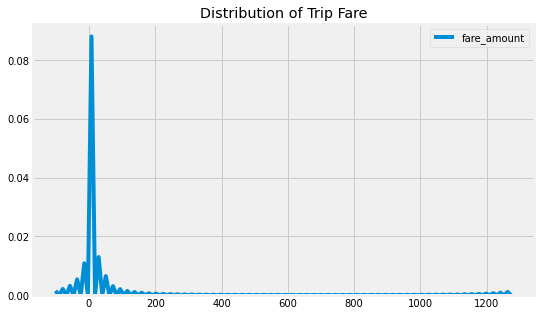

In [8]:
plt.figure(figsize=(8,5))
sns.kdeplot(train['fare_amount']).set_title("Distribution of Trip Fare")

In [9]:
train.loc[train['fare_amount']<0].shape

(262, 14)

In [10]:
train=train.loc[train['fare_amount']>=0]
train.shape

(5999738, 14)

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

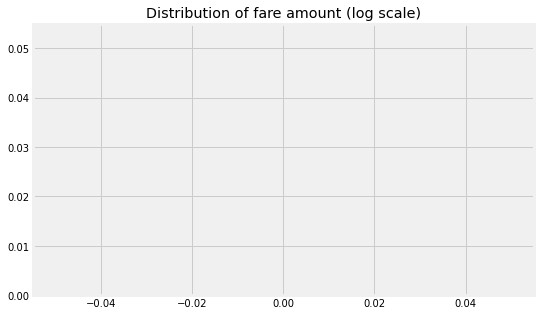

In [11]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

In [12]:
print("Range of Pickup Latitude is ", (min(train['pickup_latitude']),max(train['pickup_latitude'])))

Range of Pickup Latitude is  (-3488.079513, 3344.459268)


In [13]:
print("Range of Dropoff Latitude is ", (min(train['dropoff_latitude']),max(train['dropoff_longitude'])))

Range of Dropoff Latitude is  (-3488.079513, 3457.62235)


In [14]:
#Before we  ahead and identify outlier location, let us read the test data and see what the boundaries are.
test =  pd.read_csv('nyc_taxi_test.csv')
print("Longitude Boundary in test data")
min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max())

Longitude Boundary in test data


(-74.263242, -72.986532)

In [15]:
print("Latitude Boundary in test data")
min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max())

Latitude Boundary in test data


(40.573143, 41.709555)

In [16]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}

In [17]:
train[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0)].shape

(114137, 14)

In [18]:
train.loc[~((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
train.loc[((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(train['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)

Outlier vs Non Outlier Counts
0.0    5871295
1.0    128443 
Name: is_outlier_loc, dtype: int64


(-74.03, -73.75)

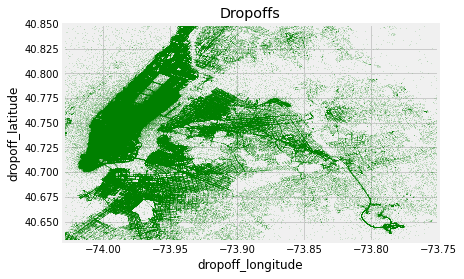

In [19]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

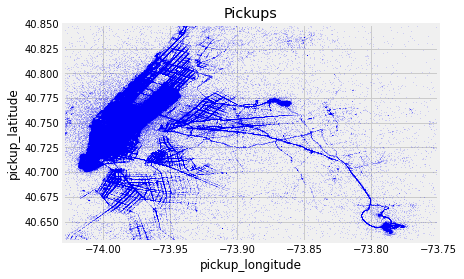

In [20]:
train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [21]:
# Let us round pickup and dropoff lat lng to 3 decimal places
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

In [22]:
pickup_fare_amount=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare'})
pickup_fare_amount.head()

,pickup_latitude_round3,pickup_longitude_round3,avg_fare
0,40.573,-74.228,8.5
1,40.573,-73.983,13.5
2,40.574,-74.243,5.7
3,40.574,-74.224,4.1
4,40.574,-74.223,4.5


In [23]:
JFK={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
JFK_center=[40.6437,-73.7900]
# Get all pickups to JFK
JFK_data=train.loc[(train.pickup_latitude>=JFK['min_lat']) & (train.pickup_latitude<=JFK['max_lat'])]
JFK_data=JFK_data.loc[(train.pickup_longitude>=JFK['min_lng']) & (train.pickup_longitude<=JFK['max_lng'])]

print("Number of Trips with Pickups from JFK",JFK_data.shape[0])

JFK_dropoff=train.loc[(train.dropoff_latitude>=JFK['min_lat']) & (train.dropoff_latitude<=JFK['max_lat'])]
JFK_dropoff=JFK_dropoff.loc[(train.dropoff_longitude>=JFK['min_lng']) & (train.dropoff_longitude<=JFK['max_lng'])]

print("Number of Trips with Dropoffs to JFK",JFK_dropoff.shape[0])

'''
# Create a folium map with JFK as the center 
m=folium.Map(location =JFK_center,zoom_start = 10,)
folium.Marker(location=JFK_center, popup='JFK Airport',icon=folium.Icon(color='black')).add_to(m)

#mc = MarkerCluster().add_to(m)
#Add markers in blue for each pickup location and line between JFK and Pickup location over time. The thickness of line indicates the fare_amount

for index,row in JFK_data.iterrows():
    folium.Marker([row['dropoff_latitude'],row['dropoff_longitude']]).add_to(m)
'''

Number of Trips with Pickups from JFK 90182
Number of Trips with Dropoffs to JFK 45609


"\n# Create a folium map with JFK as the center \nm=folium.Map(location =JFK_center,zoom_start = 10,)\nfolium.Marker(location=JFK_center, popup='JFK Airport',icon=folium.Icon(color='black')).add_to(m)\n\n#mc = MarkerCluster().add_to(m)\n#Add markers in blue for each pickup location and line between JFK and Pickup location over time. The thickness of line indicates the fare_amount\n\nfor index,row in JFK_data.iterrows():\n    folium.Marker([row['dropoff_latitude'],row['dropoff_longitude']]).add_to(m)\n"

Text(0.5, 1.0, 'Fare Amount Distribution')

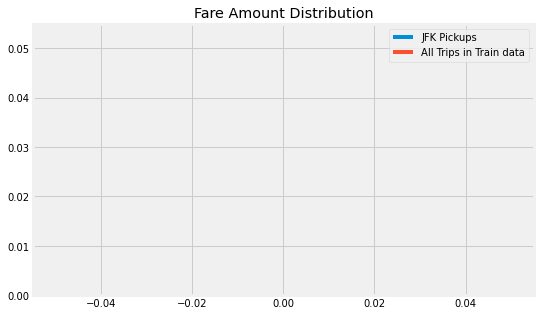

In [24]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(JFK_data['fare_amount'].values),label='JFK Pickups')
#sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK Dropoff')
sns.kdeplot(np.log(train['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution")

Text(0.5, 1.0, 'Dropoffs vs Fare Amount')

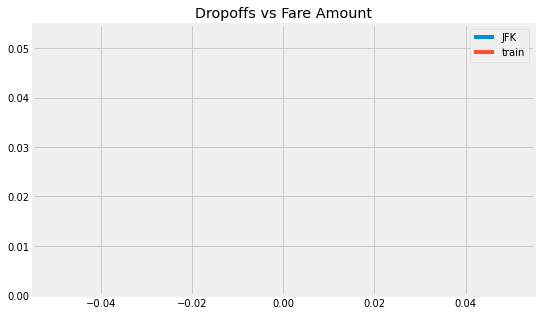

In [25]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK')
sns.kdeplot(np.log(train['fare_amount'].values),label='train')
plt.title("Dropoffs vs Fare Amount")

In [26]:
del JFK_data
del JFK
del JFK_dropoff

In [27]:
## Based on the above, let us create a function to see whether pickup or dropoff is an Airport. 

'''
def isAirport(latitude,longitude,airport_name='JFK'):
    if airport_name=='JFK':
        boundary={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
    elif airport_name=='EWR':
        boundary={
            'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        }
    elif airport_name=='la guardia':
        boundary={'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
                 }
    if latitude>=boundary['min_lat'] and latitude<=boundary['max_lat']:
        if longitude>=boundary['min_lng'] and longitude<=boundary['max_lng']:
            return 1
    else:
        return 0
        


'''

nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0
        

In [28]:
train['is_pickup_JFK']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
train['is_dropoff_JFK']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

In [29]:
train['is_pickup_EWR']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
train['is_dropoff_EWR']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

In [30]:
train['is_pickup_la_guardia']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
train['is_dropoff_la_guardia']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

In [31]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [32]:
train['trip_distance']=train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

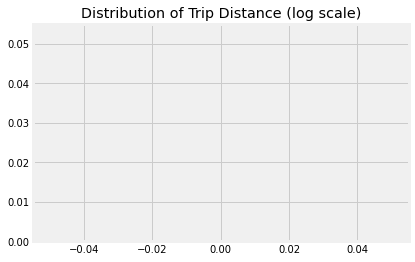

In [33]:
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Distribution of Trip Distance (log scale)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

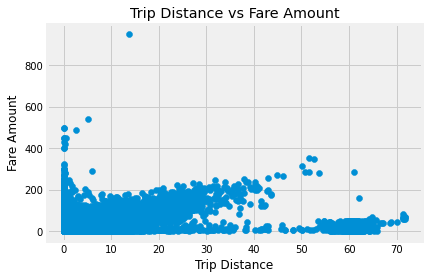

In [34]:
plt.scatter(x=train['trip_distance'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

In [35]:
non_airport=train.loc[(train['is_dropoff_JFK']==0) & (train['is_dropoff_EWR']==0) & (train['is_dropoff_la_guardia']==0)]
non_airport=non_airport.loc[(non_airport['is_pickup_JFK']==0) & (non_airport['is_pickup_EWR']==0) & (non_airport['is_pickup_la_guardia']==0)]
non_airport.shape

(5547254, 25)

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (excluding airport rides)')

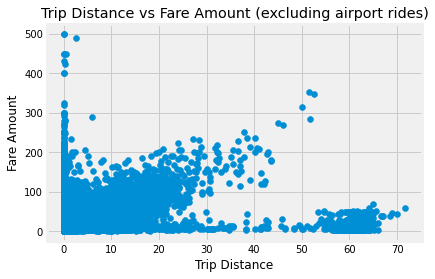

In [36]:
plt.scatter(x=non_airport['trip_distance'],y=non_airport['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport rides)")

In [37]:
non_airport_long_trips=non_airport[non_airport['trip_distance']>=50]

In [38]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
#print(pickup.shape)
### For each pickup point add a circlemarker

for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        color="blue", 
                        fill_opacity=0.9
                       ).add_to(drop_map)

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)

'''

drop_map

In [39]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490

    }
    
    
    
}

In [40]:
def getBorough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'

In [41]:
train['pickup_borough']=train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['dropoff_borough']=train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [42]:
# train.to_csv("Training_FeatureEngineering.csv",index=False)
# del train

Text(0.5, 1.0, 'Distribution of Pickup Boroughs')

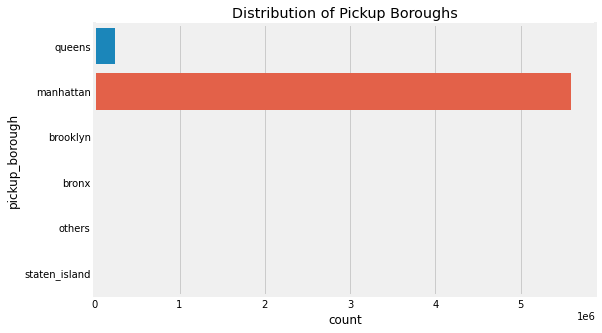

In [43]:
# train=pd.read_csv("Training_FeatureEngineering.csv")
plt.figure(figsize=(8,5))
sns.countplot(y=train['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

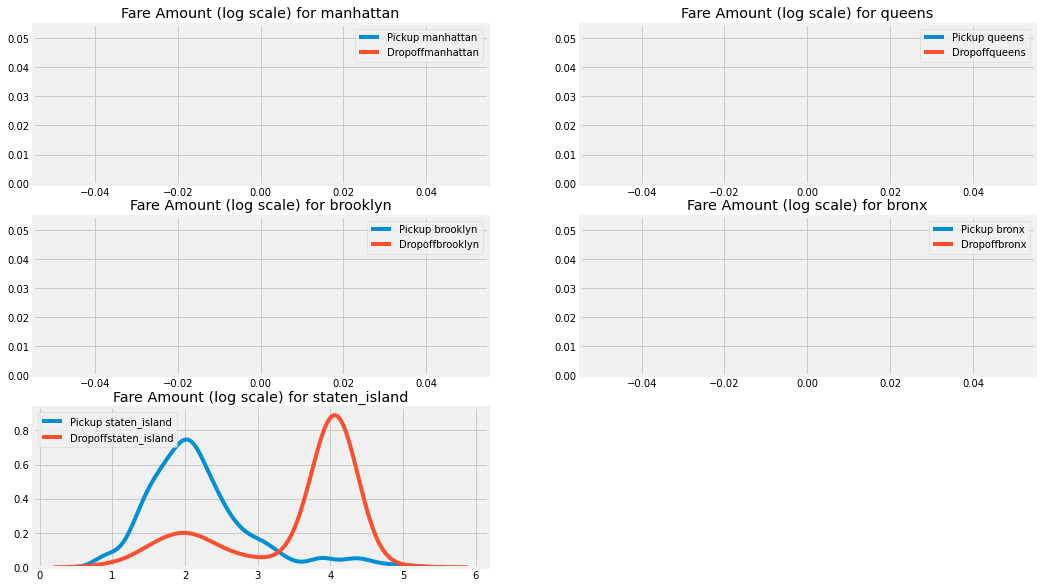

In [44]:
plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'fare_amount'].values),label='Dropoff'+ key).set_title("Fare Amount (log scale) for "+key)
    
    i=i+1

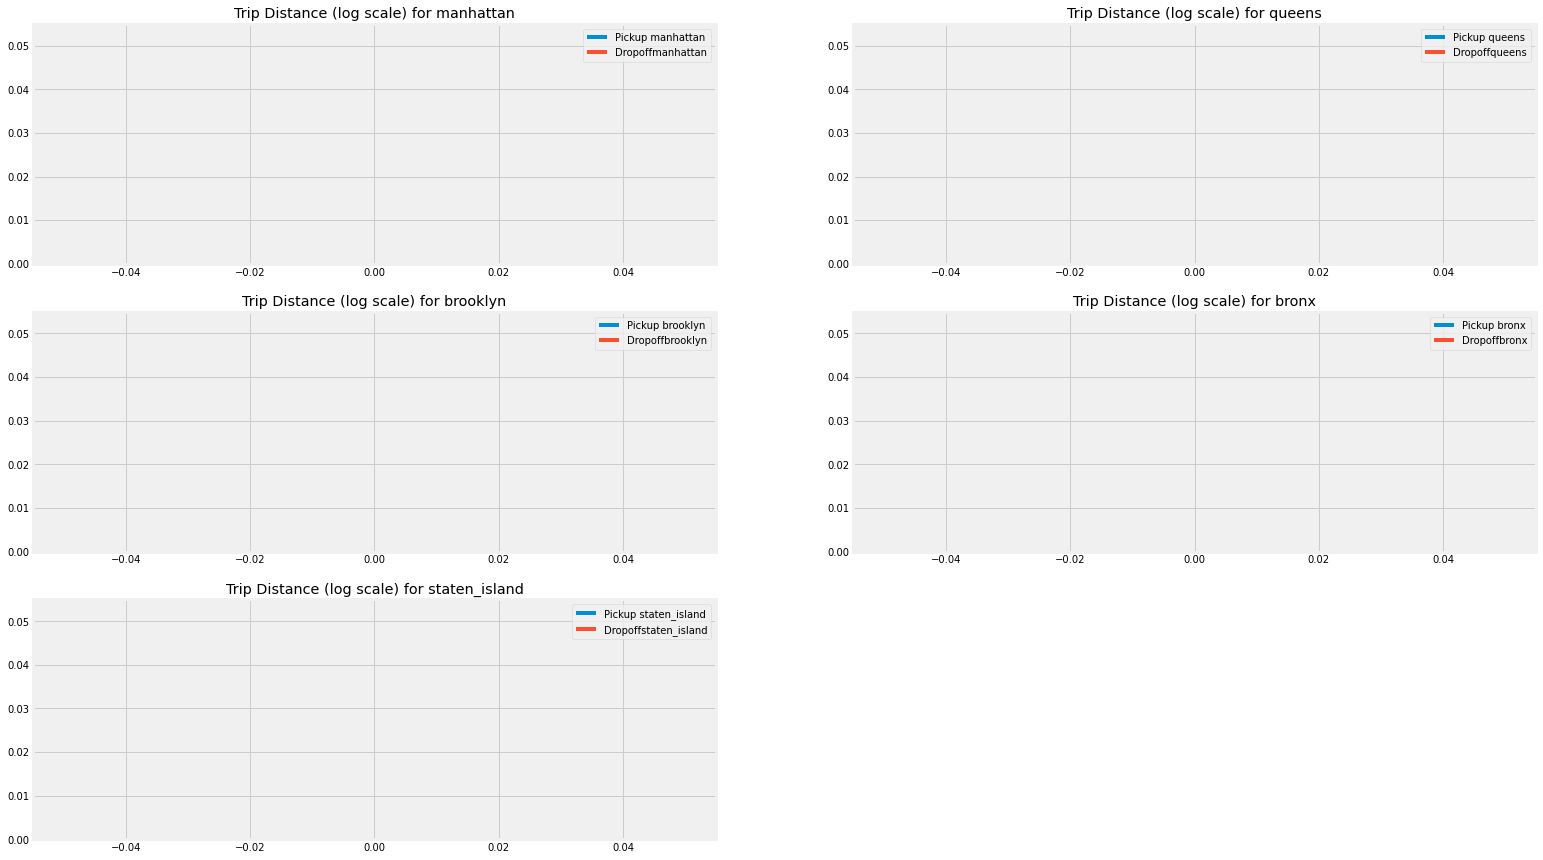

In [45]:
plt.figure(figsize=(24,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'trip_distance'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'trip_distance'].values),label='Dropoff'+ key).set_title("Trip Distance (log scale) for "+key)
    i=i+1

In [46]:
lower_manhattan_boundary={'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat>=lower_manhattan_boundary['min_lat'] and lat<=lower_manhattan_boundary['max_lat'] and lng>=lower_manhattan_boundary['min_lng'] and lng<=lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0

In [47]:
train['is_pickup_lower_manhattan']=train.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['is_dropoff_lower_manhattan']=train.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
manhattan=train.loc[(train['pickup_borough']=='manhattan') | (train['dropoff_borough']=='manhattan')]
manhattan.shape

(5778790, 29)

In [48]:
manhattan=train.loc[(train['pickup_borough']=='manhattan') | (train['dropoff_borough']=='manhattan')]
manhattan.shape

(5778790, 29)

Text(0.5, 1.0, 'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

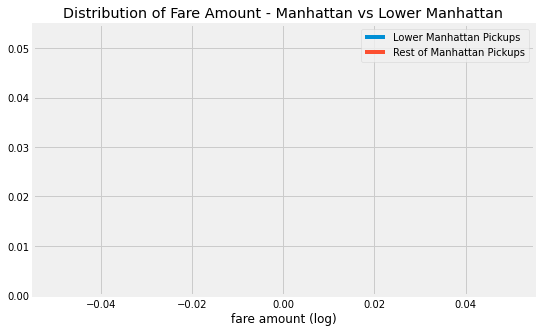

In [49]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Pickups')
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Pickups')
plt.xlabel("fare amount (log)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

Text(0.5, 1.0, 'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

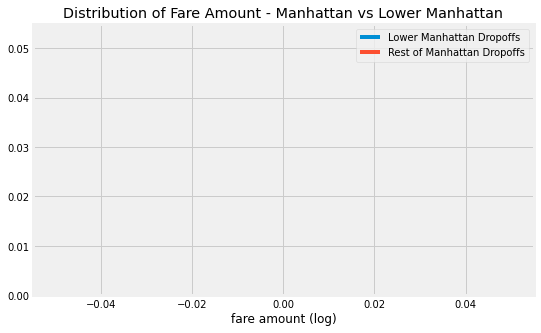

In [50]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Dropoffs')
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Dropoffs')
plt.xlabel("fare amount (log)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan pickups)')

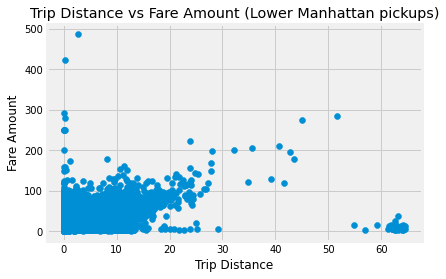

In [51]:
plt.scatter(x=manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'trip_distance'].values,y=manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Rest of Manhattan pickups)')

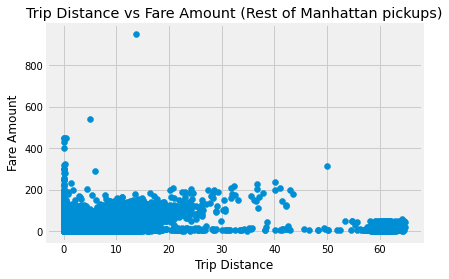

In [52]:
plt.scatter(x=manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'trip_distance'].values,y=manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan dropoffs)')

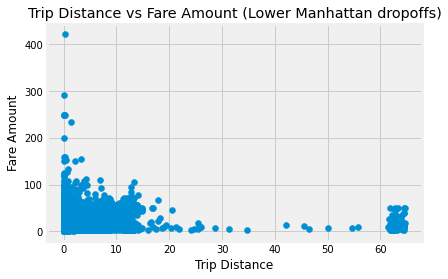

In [53]:
plt.scatter(x=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'trip_distance'].values,y=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan dropoffs)")

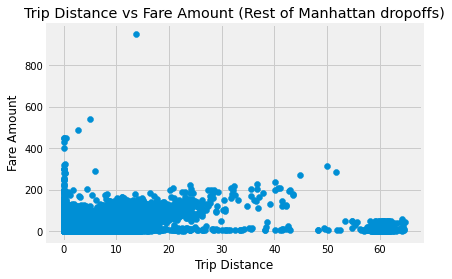

In [54]:
plt.scatter(x=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'trip_distance'].values,y=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)")

del manhattan
del non_airport_long_trips
del non_airport

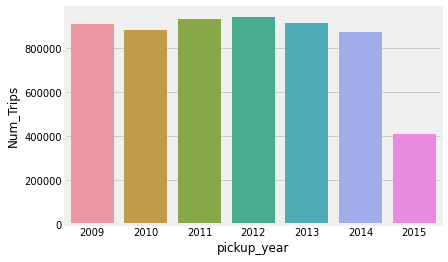

In [55]:
trips_year=train.groupby(['pickup_year'])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
trips_year.head()
sns.barplot(x='pickup_year',y='Num_Trips',data=trips_year)

In [56]:
trips_year_fareamount=train.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

Text(0.5, 1.0, 'Avg Fare Amount over Years')

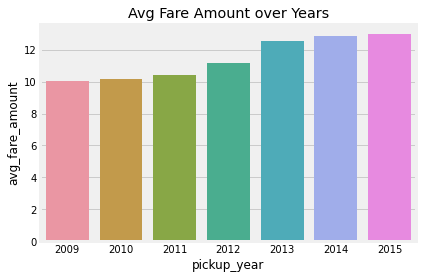

In [57]:
sns.barplot(x='pickup_year',y='avg_fare_amount',data=trips_year_fareamount).set_title("Avg Fare Amount over Years")

In [58]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=train.groupby([groupby_key])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

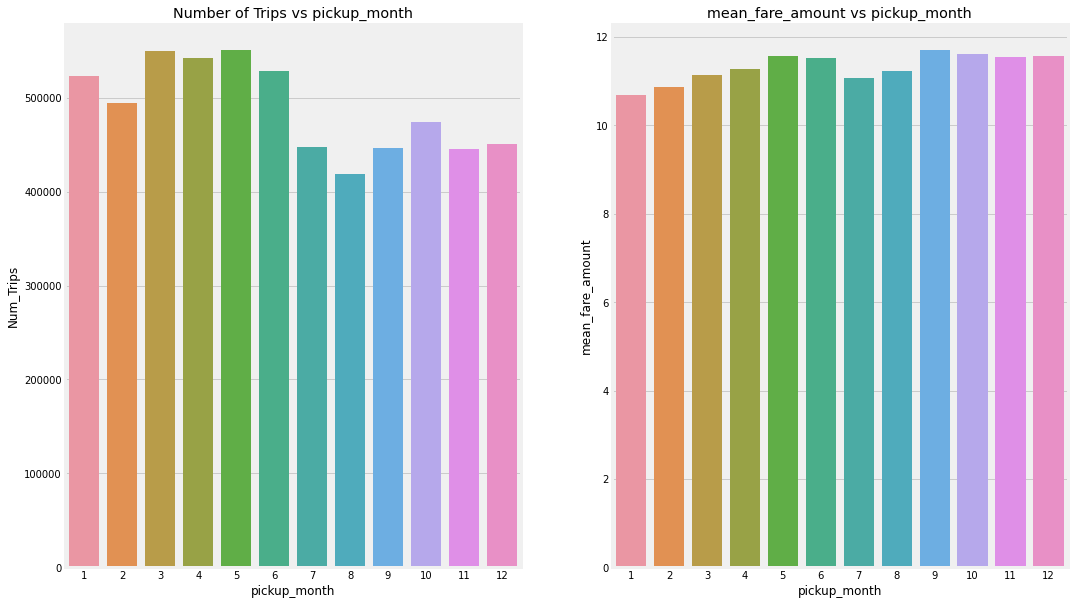

In [59]:
groupandplot(train,'pickup_month','fare_amount')

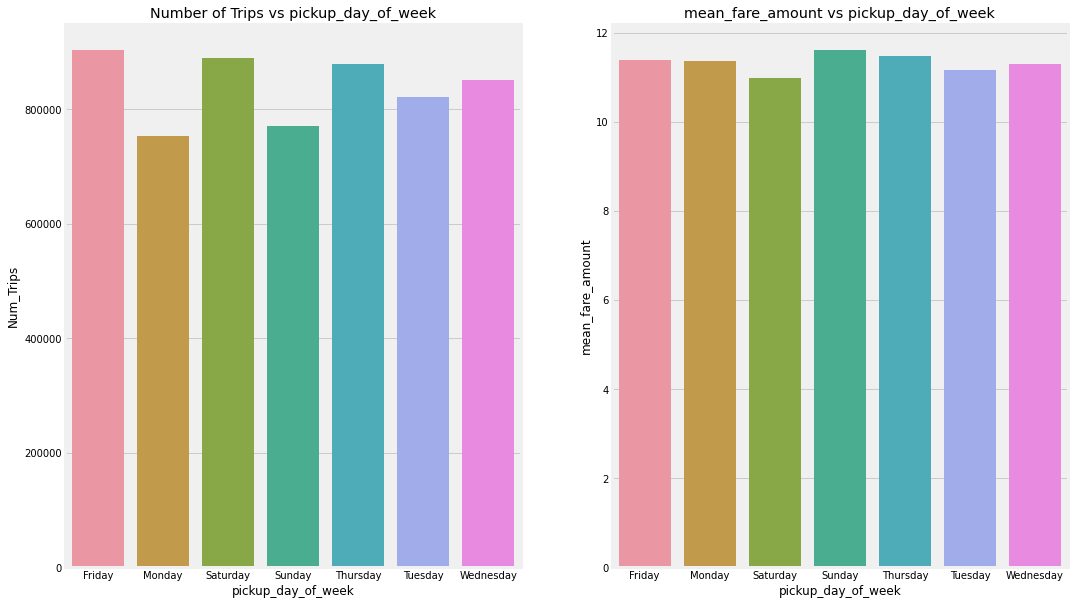

In [60]:
groupandplot(train,'pickup_day_of_week','fare_amount')

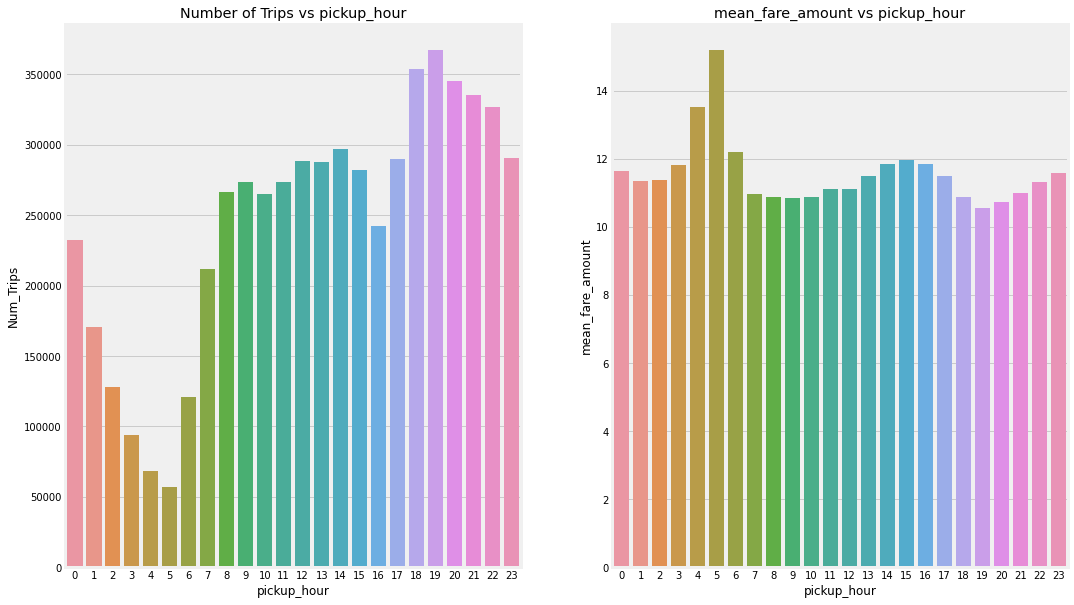

In [61]:
groupandplot(train,'pickup_hour','fare_amount')

In [62]:
# Let us encode day of the week to numbers
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [63]:
train['pickup_day_of_week']=train['pickup_day_of_week'].apply(lambda x:encodeDays(x))

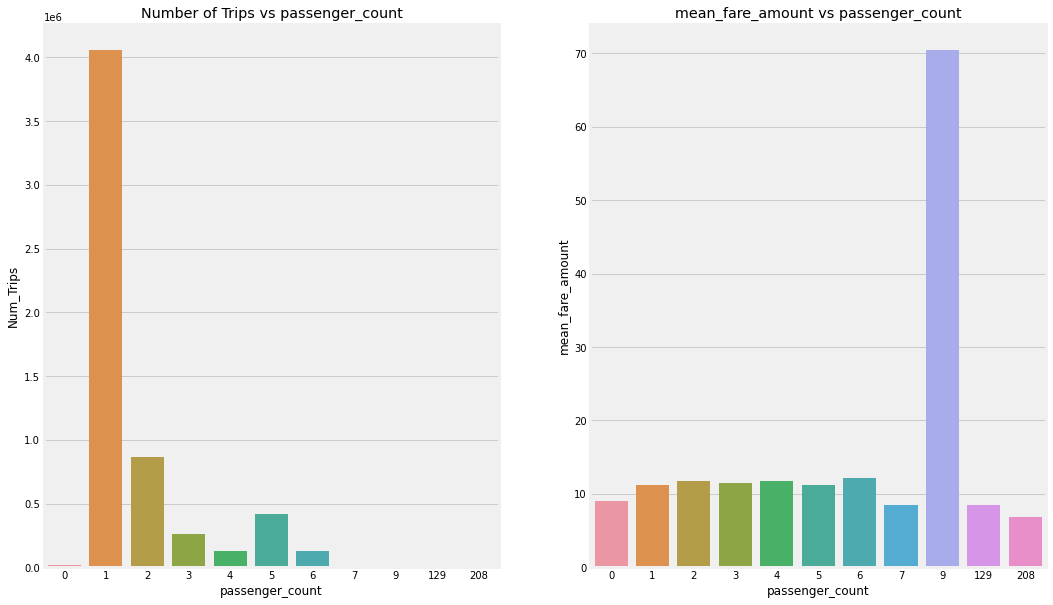

In [64]:
groupandplot(train,'passenger_count','fare_amount')

In [65]:
print("Avg trip distance (in miles) when there are zero passengers",np.mean(train.loc[train['passenger_count']==0,'trip_distance'].values))

Avg trip distance (in miles) when there are zero passengers 1.7726290784433825


In [66]:
train=train[train['passenger_count']<=8]

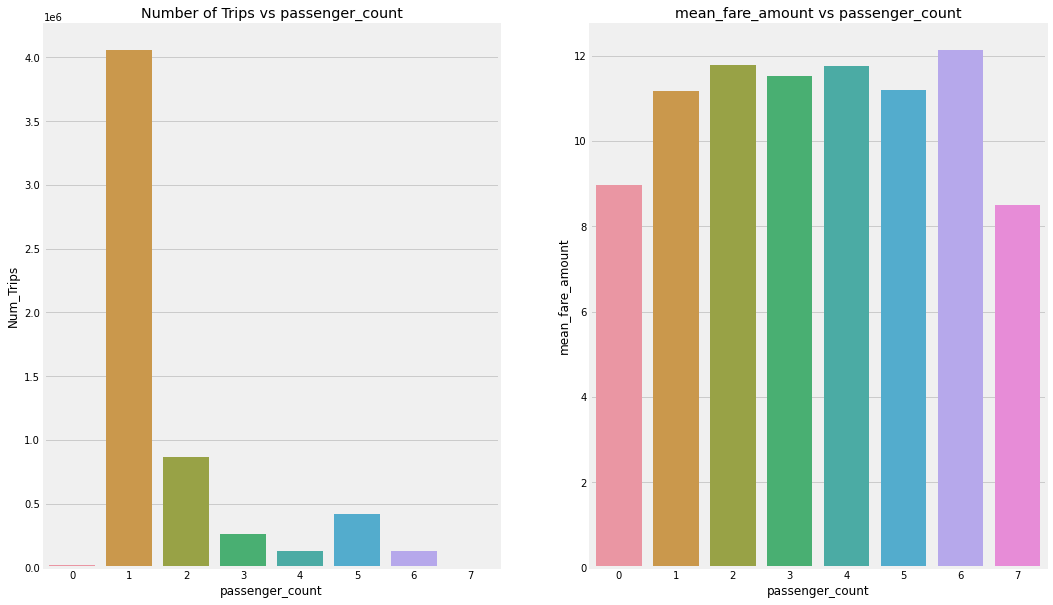

In [67]:
groupandplot(train,'passenger_count','fare_amount')

In [68]:
# train.to_csv("train_cleaned.csv",index=False)

In [69]:
test =  pd.read_csv('nyc_taxi_test.csv')
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_datetime'].apply(lambda x:x.year)
test['is_pickup_JFK']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
test['is_dropoff_JFK']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
test['is_pickup_EWR']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
test['is_dropoff_EWR']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
test['is_pickup_la_guardia']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
test['is_dropoff_la_guardia']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
test['pickup_borough']=test.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['dropoff_borough']=test.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['is_pickup_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['is_dropoff_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['pickup_day_of_week']=test['pickup_day_of_week'].apply(lambda x:encodeDays(x))
print("Shape of test data", test.shape)

# test.to_csv("test_cleaned.csv",index=False)

Shape of test data (9914, 28)
